# Model Training - By Member - Target All Chronic 

Prepared by Tan Bee Hoon, modifed by LWL

16 Aug 2022


## Import Library

In [1]:
# Need to revert to version 1.20.0 of numpy for Numba required by Shap
#!pip install numpy==1.20.0 --user

In [2]:
import random 
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import numpy as np 
from numpy import unique
from numpy import where

import pickle
from pandas import to_pickle
from pandas import read_pickle

import io
from datetime import date

from itertools import compress

# Libraries for Modelling
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn import metrics 
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE 

import shap

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Global Setting

### Import File

In [3]:
TRAINING_FILE = "member_train_data_final.pkl"

### Include Outlier Removal

In [4]:
INCL_IFOREST = 0

### Include SMOTE

In [5]:
INCL_SMOTE = 0

In [6]:
# OVERSAMPLE_RATIO set here is to oversample the minority class with SMOTE 
# it corresponds to the desired ratio of
# number of samples in minority class over number of samples the majority class after resampling.
OVERSAMPLE_RATIO = 0.3

### Adjust Train Test Ratio

In [7]:
# enter value 0<x<1 
TEST_SIZE = 0.3

### Choose SelectFromModel Algo

In [8]:
# Choose either SVC or LR
SELECT_FR_MODEL_ALGO = "SVC"

### Choose to run Shap or not

In [9]:
# Choose either 1 or 0, 1 to run shap explainer for Random Forest
RUN_SHAP = 1

## Helper Function

In [10]:
def run_model_N_eval(X_train, X_test, y_train, y_test, model="RF"):
    if model == "RF":
        #model_def = RandomForestClassifier(max_depth=20, min_samples_split=20, random_state=42)  
        model_def = RandomForestClassifier(max_depth=15, min_samples_split=40, min_samples_leaf=1, \
                                           max_features="sqrt", random_state=42)
    elif model == "LR":
        model_def = LogisticRegression(random_state=42)
    elif model == "SVM":
        model_def = svm.SVC(C=1.0, kernel='linear', probability=True, random_state=42)
    elif model == "NLSVM":
        model_def = model_def = svm.SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
    elif model == "XGB":
        model_def = XGBClassifier(max_depth=3, n_estimators=100, 
                                  reg_alpha=1, reg_lambda=1, random_state=42)
    else:
        print("WRONG model type specified")
        return None
          
    # Pipeline
    if SELECT_FR_MODEL_ALGO == "SVC":
        clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(random_state=42))), 
                        ('clf', model_def)])
    elif SELECT_FR_MODEL_ALGO == "LR":
        clf = Pipeline([('feature_selection', SelectFromModel(LogisticRegression(random_state=42))), 
                        ('clf', model_def)])
    else:
        print("Please correct the decision for SELECT_FR_MODEL_ALGO, shd be either SVC or LR")
        
    # Fit Model
    clf.fit(X_train,y_train ) 

    # Prediction
    predicted_test = clf.predict(X_test)
    predicted_train = clf.predict(X_train)
    
    # Generate Confusion Matrix
    cf_train_matrix = metrics.confusion_matrix(y_train, predicted_train)
    cf_test_matrix = metrics.confusion_matrix(y_test, predicted_test)
    
    print("Model: ", model, "\n")
    print("Labels:", y_train.unique(), "\n")
    
    print("\n","#"*100)

    print("For Training Data:")
    print(cf_train_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_train_matrix, annot=True, fmt='d', vmin=0, vmax=y_train.shape[0]/len(y_train.unique()), cmap="Blues")
    plt.title("Training Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    
    print(metrics.classification_report(y_train, predicted_train, digits=4, target_names=target_names), "\n" )
    
    report_dict_train = classification_report(y_train, predicted_train, output_dict=True)
    report_df_train = pd.DataFrame(report_dict_train)
    
    print("\n","#"*100)

    print("For Testing Data:")
    print(cf_test_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(cf_test_matrix, annot=True, fmt='d', vmin=0, vmax=y_test.shape[0]/len(y_train.unique()), cmap="Blues")
    plt.title("Testing Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    
    print(metrics.classification_report(y_test, predicted_test,  digits=4, target_names=target_names), "\n" )
    
    report_dict_test = classification_report(y_test, predicted_test, output_dict=True)
    report_df_test = pd.DataFrame(report_dict_test)

    print("\n","#"*100)
    
    return clf.named_steps['clf'], clf.named_steps['feature_selection'], report_df_train, report_df_test

In [11]:
def make_shap_waterfall_plot(shap_values, features, feature_names, num_display=20):
    column_list = feature_names
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

## Import Data

### Import Training Data

In [12]:
# Check exported data
df = read_pickle(TRAINING_FILE)

In [13]:
drop_max = [col for col in df if col.startswith('MAX_')]

In [14]:
drop_min = [col for col in df if col.startswith('MIN_')]

In [15]:
# drop redundant variables
drop_list = ['FirstBookDate','LastBookDate', "WaviedCount_NA", 
             'Mode_consult_waived_reason', "Mode_consult_hr",
             "CountVisit_chronic_list",
                "ConsultHr_0",
                "ConsultHr_8", 
                "ConsultHr_9",
                "ConsultHr_10",                 
                "ConsultHr_11",
                "ConsultHr_12",
                "ConsultHr_13",
                "ConsultHr_14",
                "ConsultHr_15",
                "ConsultHr_16",
                "ConsultHr_17",
                "ConsultHr_18",
                "ConsultHr_19",
                "ConsultHr_20",
                "ConsultHr_21",
                "ConsultHr_22",
                "ConsultHr_23"]

In [16]:
final_drop = drop_max + drop_min + drop_list

In [17]:
df.drop(final_drop, inplace = True, axis = 1)

In [18]:
pd.set_option('display.max_rows', None)
df.head(3).transpose()

,0,1,2
mem_id,0004A803-9EAB-4E3E-ACA6-F890F3805CFB,001205F3-C949-4A64-B7D8-8BB38201627C,0012A643-20F7-46B7-8A9E-9063E7A5CAA9
gender,Female,Female,Female
Mem_CountBooking,1,2,1
AVE_mc_days,5,0,5
AVE_count_diagnosis,1,1,1
AVE_count_chronic,0,0,0
AVE_count_medication,0,1,2
AVE_count_repeatmed,0,0,1
AVE_count_SymID,1,1,4
age_yr,28,50,32


In [19]:
print("Shape of data: ", df.shape)

Shape of data:  (5000, 171)


## Basic Training Data Investigation¶

In [20]:
print("Basic Data structure Info")
df.info("deep")

Basic Data structure Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 171 columns):
 #    Column                                                Dtype  
---   ------                                                -----  
 0    mem_id                                                object 
 1    gender                                                object 
 2    Mem_CountBooking                                      int64  
 3    AVE_mc_days                                           int64  
 4    AVE_count_diagnosis                                   int64  
 5    AVE_count_chronic                                     int64  
 6    AVE_count_medication                                  int64  
 7    AVE_count_repeatmed                                   int64  
 8    AVE_count_SymID                                       int64  
 9    age_yr                                                int64  
 10   WaviedCount_FOLLOW_UP                       

In [21]:
print("Basic Data Summary")
df.describe().transpose()

Basic Data Summary


,count,mean,std,min,25%,50%,75%,max
Mem_CountBooking,5000.0,2.044200e+00,1.761723,1.000000,1.000000,1.000000,2.000000,19.000000
AVE_mc_days,5000.0,9.592000e-01,1.309304,0.000000,0.000000,1.000000,1.000000,7.000000
AVE_count_diagnosis,5000.0,1.132400e+00,0.379076,1.000000,1.000000,1.000000,1.000000,5.000000
AVE_count_chronic,5000.0,8.820000e-02,0.315025,0.000000,0.000000,0.000000,0.000000,3.000000
AVE_count_medication,5000.0,1.805600e+00,1.379489,0.000000,1.000000,2.000000,3.000000,8.000000
AVE_count_repeatmed,5000.0,6.926000e-01,0.467920,0.000000,0.000000,1.000000,1.000000,5.000000
AVE_count_SymID,5000.0,1.740400e+00,1.302823,0.000000,1.000000,1.000000,2.000000,10.000000
age_yr,5000.0,3.601020e+01,10.102777,17.000000,29.000000,34.000000,41.000000,102.000000
WaviedCount_FOLLOW_UP,5000.0,3.900000e-02,0.232142,0.000000,0.000000,0.000000,0.000000,6.000000
WaviedCount_HEALTH_SCREENING_REVIEW,5000.0,3.520000e-02,0.184303,0.000000,0.000000,0.000000,0.000000,1.000000


In [22]:
df.isnull().sum()

mem_id                                                  0
gender                                                  0
Mem_CountBooking                                        0
AVE_mc_days                                             0
AVE_count_diagnosis                                     0
AVE_count_chronic                                       0
AVE_count_medication                                    0
AVE_count_repeatmed                                     0
AVE_count_SymID                                         0
age_yr                                                  0
WaviedCount_FOLLOW_UP                                   0
WaviedCount_HEALTH_SCREENING_REVIEW                     0
WaviedCount_OTHERS                                      0
WaviedCount_REFERRAL                                    0
WaviedCount_UNSUITABLE_FOR_TELECONSULT                  0
WaviedCount_WHITECOAT_FAMILY                            0
CountVisit_is_mc_issued                                 0
CountVisit_is_

In [23]:
df.duplicated().sum()

0

In [24]:
all_list = df.columns.tolist()

In [25]:
#[TODO] TO INCLUDE CATEGORICAL INPUT TO CONSIDER
cat_list = ["gender"]  
df[cat_list] = df[cat_list].astype("category")

In [26]:
#[TODO] EDIT WHERE NEC
exc_list = ['mem_id', 
            'Target_Chronic',
            'Target_Dermatitis',
            'Target_Migraine',
            'Target_Allergic',
            'Target_Gastro',
            'Target_Hypertension',
            'Target_Asthma',
            'Target_Hyperlipidaemia',
            'Target_Thyroid',
            'Target_Diabetes',
            'Target_Gout', 
            "CountVisit_Target_chronic",
            "AVE_count_chronic", 
            'CountVisit_symp_chronic_medicine_top-up',
            'CountVisit_symp_chronic_illness_management',
            "CountVisit_chronic_NoneChronic", 
            "CountVisit_chronic_Atopic_dermatitis",
            "CountVisit_chronic_Migraine",
            "CountVisit_chronic_Vasomotor_and_allergic_rhinitis",
            "CountVisit_chronic_Gastro-oesophageal_reflux_disease",
            "CountVisit_chronic_Hypertension",
            "CountVisit_chronic_Asthma",
            "CountVisit_chronic_Hyperlipidaemia",
            "CountVisit_chronic_Thyroid",
            "CountVisit_chronic_Diabetes",
            "CountVisit_chronic_Gout", 
            "CountVisit_diag_J30",  #Vasomotor and allergic rhinitis
            "CountVisit_diag_K21",  #Gastro-esophageal reflux disease
            "CountVisit_diag_G43",  #Migraine
            "CountVisit_diag_L20",  #Atopic dermatitis
            "CountVisit_diag_M10",  #Gout
            "CountVisit_diag_I10",  #hypertension
            "CountVisit_diag_J45",  #Asthma
            "CountVisit_diag_E11",  #Diabetes
            "CountVisit_diag_E78",  #hypercholesterolemia, hyperglyceridemia, Hyperlipidemia (high cholesterol), Hyperchylomicronemia 
            "CountVisit_diag_E03",  #Other hypothyroidism, i.e. Thyroid 
            "CountVisit_diag_E05",  #Thyrotoxicosis [hyperthyroidism], i.e. Thyroid
            "Target_3High",                                           
            "Target_Allergic_Dermatitis_Asthma",                                                   
            "Target_Migraine_Gastro_Thyroid_Gout",                     
            "CountVisit_symp_headache",           
            "CountVisit_symp_giddiness",             
            "CountVisit_symp_cold_sores", 
            "CountVisit_symp_rash",      
            "CountVisit_symp_sore_throat",  
            "CountVisit_symp_flu",          
            "CountVisit_symp_cough", 
            "CountVisit_symp_cold",    
            "CountVisit_symp_vomiting", 
            "CountVisit_symp_diarrhoea"
           ] 

In [27]:
select_col = [x for x in all_list if x not in exc_list] 

In [28]:
num_list = [x for x in select_col if x not in cat_list] 

In [29]:
num_list

['Mem_CountBooking',
 'AVE_mc_days',
 'AVE_count_diagnosis',
 'AVE_count_medication',
 'AVE_count_repeatmed',
 'AVE_count_SymID',
 'age_yr',
 'WaviedCount_FOLLOW_UP',
 'WaviedCount_HEALTH_SCREENING_REVIEW',
 'WaviedCount_OTHERS',
 'WaviedCount_REFERRAL',
 'WaviedCount_UNSUITABLE_FOR_TELECONSULT',
 'WaviedCount_WHITECOAT_FAMILY',
 'CountVisit_is_mc_issued',
 'CountVisit_is_referral_letter_issued',
 'CountVisit_diag_H57',
 'CountVisit_diag_M23',
 'CountVisit_diag_T88',
 'CountVisit_diag_R51',
 'CountVisit_diag_N94',
 'CountVisit_diag_G44',
 'CountVisit_diag_M79',
 'CountVisit_diag_J02',
 'CountVisit_diag_J06',
 'CountVisit_diag_R21',
 'CountVisit_diag_M62',
 'CountVisit_diag_A09',
 'CountVisit_diag_L30',
 'CountVisit_diag_T78',
 'CountVisit_diag_U07',
 'CountVisit_diag_K29',
 'CountVisit_diag_B35',
 'CountVisit_diag_K30',
 'CountVisit_diag_H81',
 'CountVisit_diag_N39',
 'CountVisit_diag_G47',
 'CountVisit_diag_Z76',
 'CountVisit_diag_K59',
 'CountVisit_diag_H10',
 'CountVisit_diag_R42',


## One Hot encoding

In [30]:
enc_df = pd.get_dummies(df[cat_list])

In [31]:
# Drop "gender_Unknown"
drop_oneHot = ["gender_Female", "gender_Male"]

In [32]:
#[TODO] TO EDIT AND DROP ONE CATEGORY LEVEL FOR ONE-HOT
enc_df = enc_df[drop_oneHot]

## Define input and output

In [33]:
# merge with numerical df for input
X = df[num_list].join(enc_df)   

In [34]:
X.shape

(5000, 121)

In [35]:
# Define the Target
y = df["Target_Chronic"]  #[TODO] TO EDIT AND DEFINE TARGET LABEL 

In [36]:
# Check input variable names
feature_names = X.columns.tolist()

In [37]:
# EXPORT PICKLE
# export training Feature List for deployment
PKL_ALL_FEATURE_FILENAME = "model_all_featurelist.pkl"
with open(PKL_ALL_FEATURE_FILENAME, "wb") as file:
    pickle.dump(feature_names, file)

## Train Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

In [39]:
y.value_counts()

0    4156
1     844
Name: Target_Chronic, dtype: int64

In [40]:
y.value_counts(normalize=True)[1] * 100

16.88

## Oversample for Training

In [41]:
#[TODO] TO INCLUDE IF DATA TARGET CLASS TOO IMBALANCE

In [42]:
print(f'''Shape of X train without balancing: {X_train.shape}''')
print(f'''% Positive class of X train without balancing = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}''')

Shape of X train without balancing: (3500, 121)
% Positive class of X train without balancing = 16.89


In [43]:
# OVERSAMPLE_RATIO set here is to oversample the minority class with SMOTE 
# it corresponds to the desired ratio of
# number of samples in minority class over number of samples the majority class after resampling.
if INCL_SMOTE == 1:
    sm = SMOTE(random_state=42, sampling_strategy=OVERSAMPLE_RATIO)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(f'''Shape of X train after SMOTE: {X_train.shape}''')
    print(f'''% Positive class of X train after SMOTE = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}''')
else: 
    print("SMOTE not included.")

SMOTE not included.


In [44]:
print("SMOTE over-sampling is not done for Test data")
print(f'''Shape of X Test after SMOTE: {X_test.shape}''')
print(f'''% Positive class f X Test before SMOTE = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

SMOTE over-sampling is not done for Test data
Shape of X Test after SMOTE: (1500, 121)
% Positive class f X Test before SMOTE = 16.87


Note: Not over-sampling for Test data to maintain data integrity

## Remove Outliers

Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.

It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.

The method is based on two anomalies’ quantitative properties:

i) they are the minority consisting of fewer instances and 

ii) they have attribute-values that are very different from those of normal instances.
The scikit-learn library provides an implementation of Isolation Forest in the IsolationForest class.

In [45]:
# identify outliers in the training dataset

if INCL_IFOREST ==1: 
    iso = IsolationForest(contamination=0.1,random_state= 0)
    yhat = iso.fit_predict(X_train)

    # select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    print("No of outliers marked: ")
    sum(yhat == -1)
    
    # summarize the shape of the updated training dataset
    print("Shape of processed dataset, X_train vs y_train after removing outliers")
    print(X_train.shape, y_train.shape)

## Standardized Data

In [46]:
sc =  StandardScaler()
# Fit and Transform the training dataset
print("Fit and Transform the training dataset")
X_train = sc.fit_transform(X_train)

Fit and Transform the training dataset


In [47]:
X_train

array([[-0.60350142, -0.73873834, -0.35585544, ...,  0.0263817 ,
         0.81212948, -0.74814089],
       [-0.01822711,  1.54131825, -0.35585544, ...,  0.20490237,
         0.81212948, -0.74814089],
       [ 0.56704719,  0.02128053, -0.35585544, ...,  2.75254216,
         0.81212948, -0.74814089],
       ...,
       [-0.60350142, -0.73873834,  2.31687854, ...,  0.0263817 ,
        -1.23133075,  1.33664663],
       [-0.60350142, -0.73873834, -0.35585544, ...,  0.0263817 ,
        -1.23133075,  1.33664663],
       [ 1.1523215 ,  0.02128053, -0.35585544, ...,  0.42818156,
         0.81212948, -0.74814089]])

In [48]:
# Transform the testing dataset
print("Transform the testing dataset (no fitting)")
X_test = sc.transform (X_test)

Transform the testing dataset (no fitting)


In [49]:
# EXPORT PICKLE
PKL_STANDARDSCALER_FILENAME = "model_all_standardard_scaler.pkl"
with open(PKL_STANDARDSCALER_FILENAME, "wb") as file:
    pickle.dump(sc, file)

## Model Selection

In [50]:
target_names = ['Non-Chronic', 'Chronic']   #Define Target Names

### Logistic Model

Model:  LR 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[2821   88]
 [ 342  249]] 



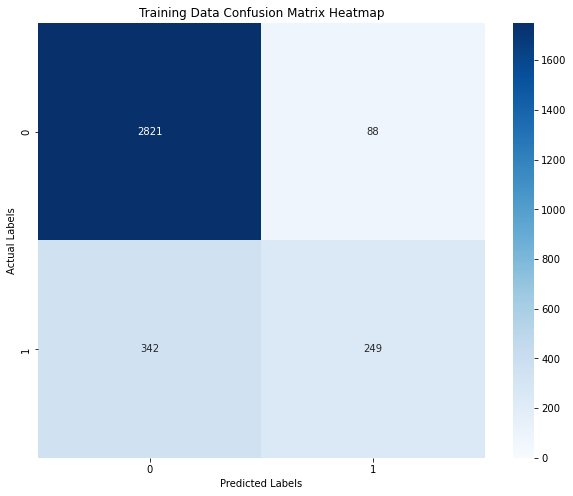

              precision    recall  f1-score   support

 Non-Chronic     0.8919    0.9697    0.9292      2909
     Chronic     0.7389    0.4213    0.5366       591

    accuracy                         0.8771      3500
   macro avg     0.8154    0.6955    0.7329      3500
weighted avg     0.8660    0.8771    0.8629      3500
 


 ####################################################################################################
For Testing Data:
[[1206   41]
 [ 140  113]] 



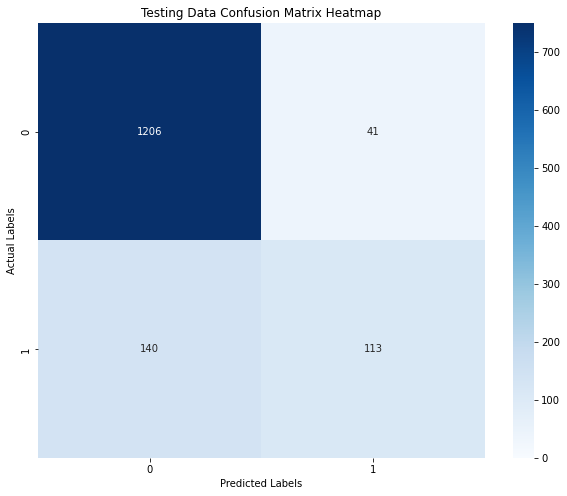

              precision    recall  f1-score   support

 Non-Chronic     0.8960    0.9671    0.9302      1247
     Chronic     0.7338    0.4466    0.5553       253

    accuracy                         0.8793      1500
   macro avg     0.8149    0.7069    0.7427      1500
weighted avg     0.8686    0.8793    0.8670      1500
 


 ####################################################################################################


In [51]:
LR_model, LR_selectFeature, LR_report_train, LR_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, model="LR")

In [52]:
# LR Target Report 
LR_frame = { 'Train': LR_report_train["1"], 'Test': LR_report_test["1"] }
LR_report_output= pd.DataFrame(LR_frame)
LR_report_output

,Train,Test
precision,0.738872,0.733766
recall,0.421320,0.446640
f1-score,0.536638,0.555283
support,591.000000,253.000000


In [53]:
# EXPORT PICKLE
# export result
PKL_LR_RESULT_FILENAME = "model_all_result_logistic.pkl"
with open(PKL_LR_RESULT_FILENAME, "wb") as file:
    pickle.dump(LR_report_output, file)

### Support Vector Machine (Linear)

Model:  SVM 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[2845   64]
 [ 393  198]] 



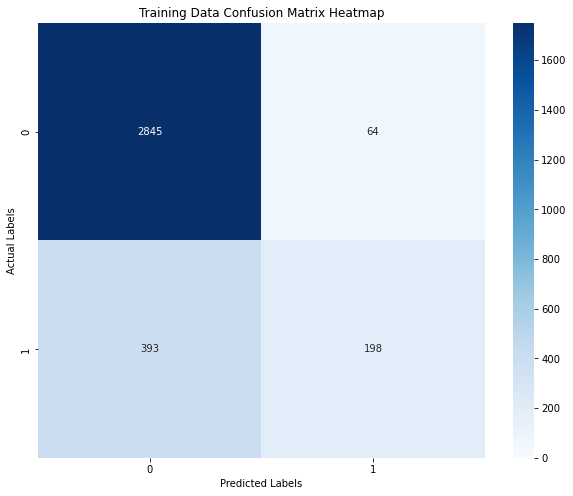

              precision    recall  f1-score   support

 Non-Chronic     0.8786    0.9780    0.9257      2909
     Chronic     0.7557    0.3350    0.4642       591

    accuracy                         0.8694      3500
   macro avg     0.8172    0.6565    0.6949      3500
weighted avg     0.8579    0.8694    0.8477      3500
 


 ####################################################################################################
For Testing Data:
[[1214   33]
 [ 157   96]] 



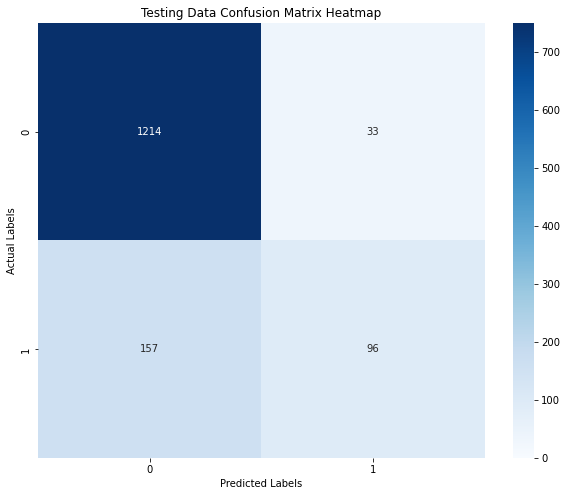

              precision    recall  f1-score   support

 Non-Chronic     0.8855    0.9735    0.9274      1247
     Chronic     0.7442    0.3794    0.5026       253

    accuracy                         0.8733      1500
   macro avg     0.8148    0.6765    0.7150      1500
weighted avg     0.8617    0.8733    0.8558      1500
 


 ####################################################################################################


In [54]:
SVM_model, SVM_selectFeature, SVM_report_train, SVM_report_test= \
    run_model_N_eval(X_train, X_test, y_train, y_test, "SVM")

In [55]:
# SVM Target Report 
SVM_frame = { 'Train': SVM_report_train["1"], 'Test': SVM_report_test["1"] }
SVM_report_output= pd.DataFrame(SVM_frame)
SVM_report_output

,Train,Test
precision,0.755725,0.744186
recall,0.335025,0.379447
f1-score,0.464244,0.502618
support,591.000000,253.000000


In [56]:
# EXPORT PICKLE
# export result
PKL_SVM_RESULT_FILENAME = "model_all_result_svm.pkl"
with open(PKL_SVM_RESULT_FILENAME, "wb") as file:
    pickle.dump(SVM_report_output, file)

### Support Vector Machine (Non-Linear)

Model:  NLSVM 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[2879   30]
 [ 338  253]] 



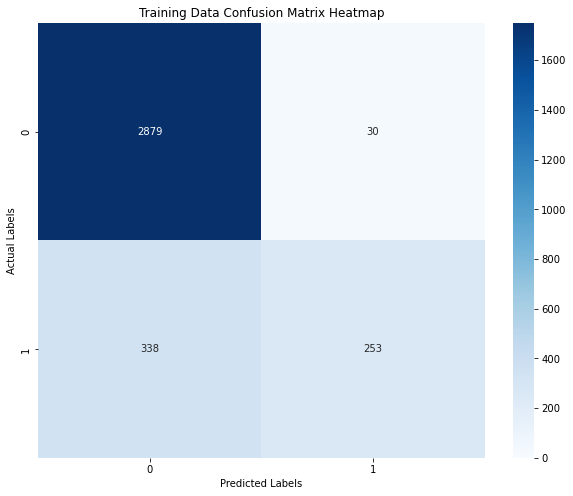

              precision    recall  f1-score   support

 Non-Chronic     0.8949    0.9897    0.9399      2909
     Chronic     0.8940    0.4281    0.5789       591

    accuracy                         0.8949      3500
   macro avg     0.8945    0.7089    0.7594      3500
weighted avg     0.8948    0.8949    0.8790      3500
 


 ####################################################################################################
For Testing Data:
[[1229   18]
 [ 193   60]] 



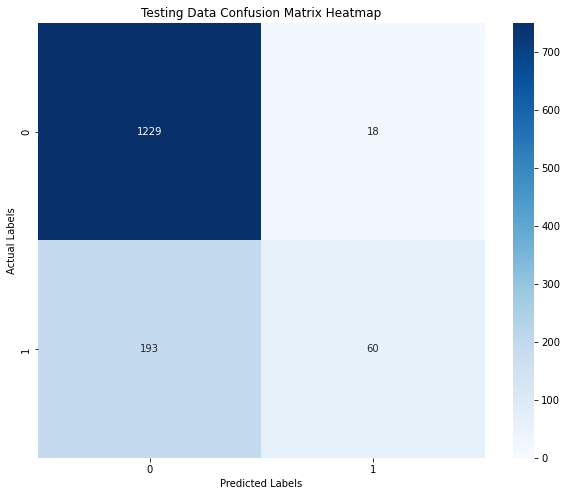

              precision    recall  f1-score   support

 Non-Chronic     0.8643    0.9856    0.9209      1247
     Chronic     0.7692    0.2372    0.3625       253

    accuracy                         0.8593      1500
   macro avg     0.8168    0.6114    0.6417      1500
weighted avg     0.8482    0.8593    0.8268      1500
 


 ####################################################################################################


In [57]:
NLSVM_model, NLSVM_selectFeature, NLSVM_report_train, NLSVM_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "NLSVM")

In [58]:
# NLSVM Target Report 
NLSVM_frame = { 'Train': NLSVM_report_train["1"], 'Test': NLSVM_report_test["1"] }
NLSVM_report_output= pd.DataFrame(NLSVM_frame)
NLSVM_report_output

,Train,Test
precision,0.893993,0.769231
recall,0.428088,0.237154
f1-score,0.578947,0.362538
support,591.000000,253.000000


In [59]:
# EXPORT PICKLE
# export result
PKL_NLSVM_RESULT_FILENAME = "model_all_result_nonlinearsvm.pkl"
with open(PKL_NLSVM_RESULT_FILENAME, "wb") as file:
    pickle.dump(NLSVM_report_output, file)

### Random Forest

Model:  RF 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[2900    9]
 [ 423  168]] 



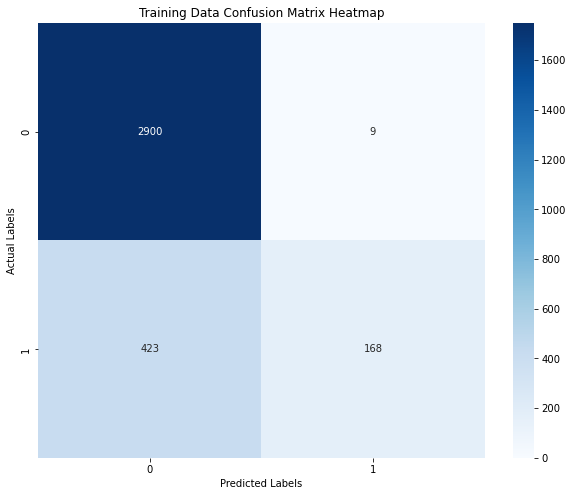

              precision    recall  f1-score   support

 Non-Chronic     0.8727    0.9969    0.9307      2909
     Chronic     0.9492    0.2843    0.4375       591

    accuracy                         0.8766      3500
   macro avg     0.9109    0.6406    0.6841      3500
weighted avg     0.8856    0.8766    0.8474      3500
 


 ####################################################################################################
For Testing Data:
[[1233   14]
 [ 195   58]] 



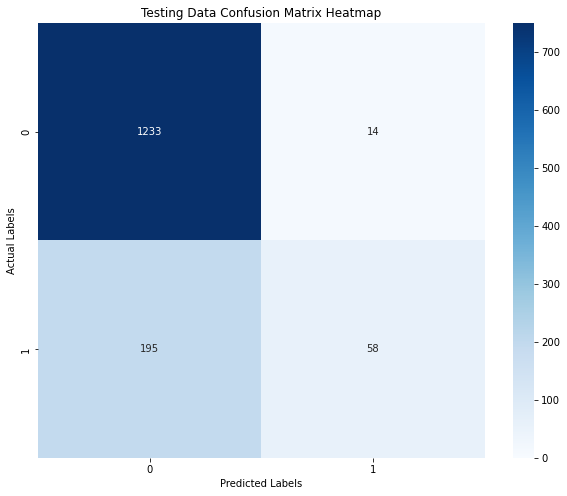

              precision    recall  f1-score   support

 Non-Chronic     0.8634    0.9888    0.9219      1247
     Chronic     0.8056    0.2292    0.3569       253

    accuracy                         0.8607      1500
   macro avg     0.8345    0.6090    0.6394      1500
weighted avg     0.8537    0.8607    0.8266      1500
 


 ####################################################################################################


In [60]:
RF_model, RF_selectFeature, RF_report_train, RF_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "RF")

In [61]:
# RF Target Report 
RF_frame = { 'Train': RF_report_train["1"], 'Test': RF_report_test["1"] }
RF_report_output= pd.DataFrame(RF_frame)
RF_report_output

,Train,Test
precision,0.949153,0.805556
recall,0.284264,0.229249
f1-score,0.437500,0.356923
support,591.000000,253.000000


In [62]:
# EXPORT PICKLE
# export result
PKL_RF_RESULT_FILENAME = "model_all_result_randomforest.pkl"
with open(PKL_RF_RESULT_FILENAME, "wb") as file:
    pickle.dump(RF_report_output, file)

### XGBoost

[09:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model:  XGB 

Labels: [0 1] 


 ####################################################################################################
For Training Data:
[[2859   50]
 [ 313  278]] 



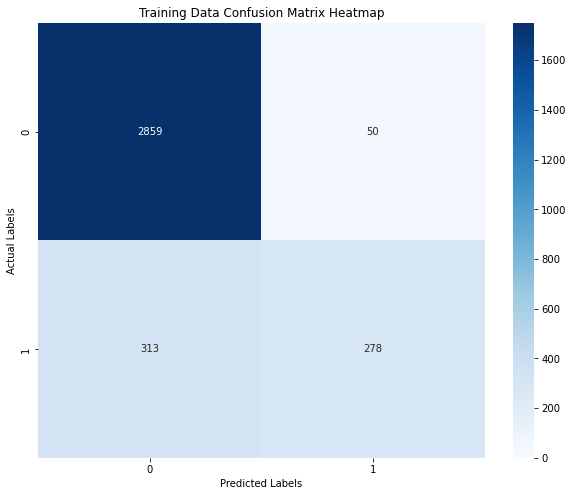

              precision    recall  f1-score   support

 Non-Chronic     0.9013    0.9828    0.9403      2909
     Chronic     0.8476    0.4704    0.6050       591

    accuracy                         0.8963      3500
   macro avg     0.8744    0.7266    0.7727      3500
weighted avg     0.8922    0.8963    0.8837      3500
 


 ####################################################################################################
For Testing Data:
[[1209   38]
 [ 140  113]] 



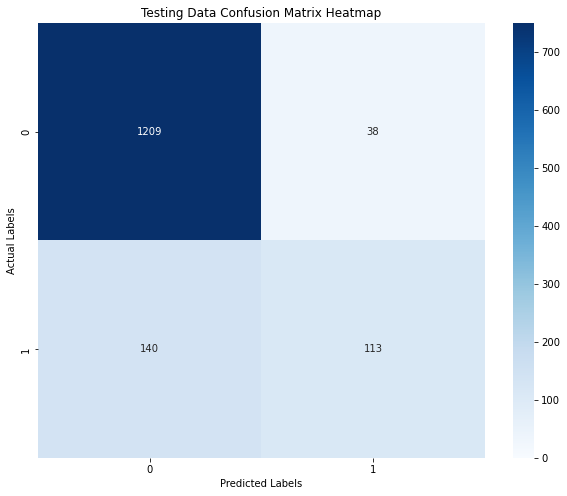

              precision    recall  f1-score   support

 Non-Chronic     0.8962    0.9695    0.9314      1247
     Chronic     0.7483    0.4466    0.5594       253

    accuracy                         0.8813      1500
   macro avg     0.8223    0.7081    0.7454      1500
weighted avg     0.8713    0.8813    0.8687      1500
 


 ####################################################################################################


In [63]:
XGB_model, XGB_selectFeature, XGB_report_train, XGB_report_test = \
    run_model_N_eval(X_train, X_test, y_train, y_test, "XGB")

In [64]:
# XGB Target Report 
XGB_frame = { 'Train': XGB_report_train["1"], 'Test': XGB_report_test["1"] }
XGB_report_output= pd.DataFrame(XGB_frame)
XGB_report_output

,Train,Test
precision,0.847561,0.748344
recall,0.470389,0.446640
f1-score,0.605005,0.559406
support,591.000000,253.000000


In [65]:
# EXPORT PICKLE
# export result
PKL_XGB_RESULT_FILENAME = "model_all_result_xgb.pkl"
with open(PKL_XGB_RESULT_FILENAME, "wb") as file:
    pickle.dump(XGB_report_output, file)

## Feature Selected

In [66]:
# EXPORT PICKLE
PKL_SELECT_MODEL_FILENAME = "model_all_selectfeature.pkl"
with open(PKL_SELECT_MODEL_FILENAME, "wb") as file:
    pickle.dump(LR_selectFeature, file)

In [67]:
X_newTest_LR = LR_selectFeature.transform(X_test)
X_newTrain_LR = LR_selectFeature.transform(X_train)
feature_idx_LR = LR_selectFeature.get_support()
final_selectList_LR = list(compress(feature_names, feature_idx_LR))
len(final_selectList_LR)

34

In [68]:
final_selectList_LR

['Mem_CountBooking',
 'AVE_count_diagnosis',
 'AVE_count_medication',
 'CountVisit_diag_H57',
 'CountVisit_diag_T88',
 'CountVisit_diag_R51',
 'CountVisit_diag_N94',
 'CountVisit_diag_G44',
 'CountVisit_diag_M79',
 'CountVisit_diag_J02',
 'CountVisit_diag_J06',
 'CountVisit_diag_R21',
 'CountVisit_diag_M62',
 'CountVisit_diag_A09',
 'CountVisit_diag_U07',
 'CountVisit_diag_K29',
 'CountVisit_diag_K30',
 'CountVisit_diag_H81',
 'CountVisit_diag_N39',
 'CountVisit_diag_R42',
 'CountVisit_diag_S90',
 'CountVisit_diag_M54',
 'CountVisit_diag_B37',
 'CountVisit_diag_H00',
 'CountVisit_diag_R52',
 'CountVisit_diag_Z71',
 'CountVisit_diag_Y42',
 'CountVisit_diag_J03',
 'CountVisit_diag_N64',
 'ConsultHr_8to10',
 'ConsultHr_11to13',
 'ConsultHr_14to17',
 'ConsultHr_18to21',
 'Prin1_sym_common']

In [69]:
X_newTest_SVM = SVM_selectFeature.transform(X_test)
X_newTrain_SVM = SVM_selectFeature.transform(X_train)
feature_idx_SVM = SVM_selectFeature.get_support()
final_selectList_SVM = list(compress(feature_names, feature_idx_SVM))
len(final_selectList_SVM)

34

In [70]:
X_newTest_NLSVM = NLSVM_selectFeature.transform(X_test)
X_newTrain_NLSVM = NLSVM_selectFeature.transform(X_train)
feature_idx_NLSVM = NLSVM_selectFeature.get_support()
final_selectList_NLSVM = list(compress(feature_names, feature_idx_NLSVM))
len(final_selectList_NLSVM)

34

In [71]:
X_newTest_RF = RF_selectFeature.transform(X_test)
X_newTrain_RF = RF_selectFeature.transform(X_train)
feature_idx_RF = RF_selectFeature.get_support()
final_selectList_RF = list(compress(feature_names, feature_idx_RF))
len(final_selectList_RF)

34

In [72]:
X_newTest_XGB = XGB_selectFeature.transform(X_test)
X_newTrain_XGB = XGB_selectFeature.transform(X_train)
feature_idx_XGB = XGB_selectFeature.get_support()
final_selectList_XGB = list(compress(feature_names, feature_idx_XGB))
len(final_selectList_XGB)

34

## ROC

In [73]:
# EXPORT PICKLE
#Export LR_model for deployment
PKL_LR_MODEL_FILENAME = "model_all_logistic.pkl"
with open(PKL_LR_MODEL_FILENAME, "wb") as file:
    pickle.dump(LR_model, file)

In [74]:
# EXPORT PICKLE
#Export SVM_model for deployment
PKL_SVM_MODEL_FILENAME = "model_all_svm.pkl"
with open(PKL_SVM_MODEL_FILENAME, "wb") as file:
    pickle.dump(SVM_model, file)

In [75]:
# EXPORT PICKLE
#Export Non-linear SVM_model for deployment
PKL_NLSVM_MODEL_FILENAME = "model_all_nonlinear_svm.pkl"
with open(PKL_NLSVM_MODEL_FILENAME, "wb") as file:
    pickle.dump(NLSVM_model, file)

In [76]:
# EXPORT PICKLE
#Export RF_model for deployment
PKL_RF_MODEL_FILENAME = "model_all_randomforest.pkl"
with open(PKL_RF_MODEL_FILENAME, "wb") as file:
    pickle.dump(RF_model, file)

In [77]:
# EXPORT PICKLE
#Export XGB_model for deployment
PKL_XGB_MODEL_FILENAME = "model_all_xgb.pkl"
with open(PKL_XGB_MODEL_FILENAME, "wb") as file:
    pickle.dump(XGB_model, file)

In [78]:
lr_probs = LR_model.predict_proba(X_newTest_LR)[:,1]
lr_auc = roc_auc_score(y_test, lr_probs, average=None)
lr_auc = round(lr_auc,5)
lr_auc

0.87363

In [79]:
svm_probs = SVM_model.predict_proba(X_newTest_SVM)[:,1]
svm_auc = roc_auc_score(y_test, svm_probs, average=None)
svm_auc = round(svm_auc,5)
svm_auc

0.8778

In [80]:
nlsvm_probs = NLSVM_model.predict_proba(X_newTest_NLSVM)[:,1]
nlsvm_auc = roc_auc_score(y_test, nlsvm_probs, average=None)
nlsvm_auc = round(nlsvm_auc, 5)
nlsvm_auc

0.86184

In [81]:
rf_probs = RF_model.predict_proba(X_newTest_RF)[:,1]
rf_auc = roc_auc_score(y_test, rf_probs, average=None)
rf_auc = round(rf_auc, 5)
rf_auc

0.84399

In [82]:
xgb_probs = XGB_model.predict_proba(X_newTest_XGB)[:,1]
xgb_auc = roc_auc_score(y_test, xgb_probs, average=None)
xgb_auc = round(xgb_auc, 5)
xgb_auc

0.8749

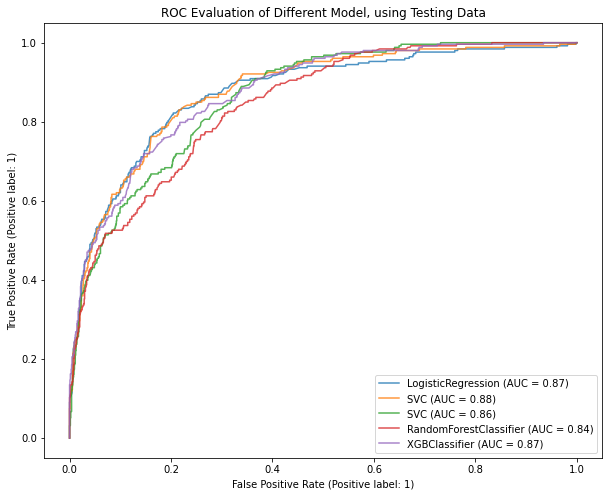

In [83]:
%matplotlib inline
plt.figure(figsize=(10,8))
ax = plt.gca()
LR_disp = RocCurveDisplay.from_estimator(LR_model, X_newTest_LR, y_test, ax=ax, alpha=0.8)
SVM_disp = RocCurveDisplay.from_estimator(SVM_model, X_newTest_SVM, y_test, ax=ax, alpha=0.8)
NLSVM_disp = RocCurveDisplay.from_estimator(NLSVM_model, X_newTest_NLSVM, y_test, ax=ax, alpha=0.8)
RF_disp = RocCurveDisplay.from_estimator(RF_model, X_newTest_RF, y_test, ax=ax, alpha=0.8)
XGB_disp = RocCurveDisplay.from_estimator(XGB_model, X_newTest_XGB, y_test, ax=ax, alpha=0.8)
plt.title("ROC Evaluation of Different Model, using Testing Data")
plt.show()

## Model Explanability

### Random Forest 

EXPLAIN THE EFFECT OF FEATURES ON TARGET CLASS USING SHAP VALUES


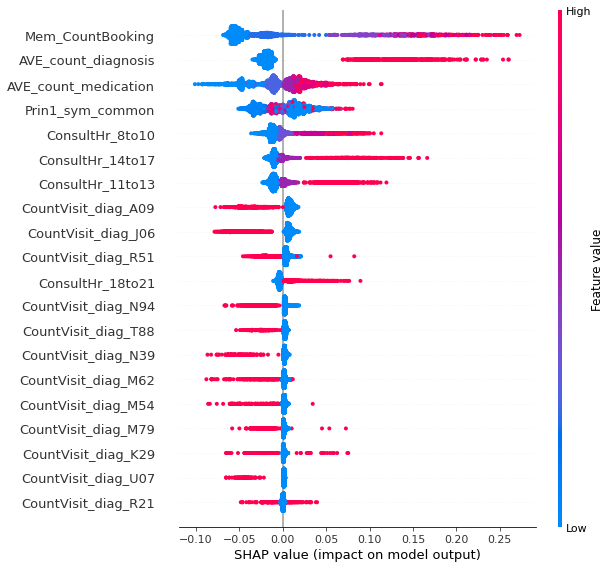

In [84]:
if RUN_SHAP == 1:
    # [TODO] To choose the final model and correct selected features selected
    MODEL_SELECTED = RF_model
    X_TRAIN = X_newTrain_RF
    X_TEST = X_newTest_RF
    FINAL_LIST = final_selectList_RF

    explainer = shap.TreeExplainer(MODEL_SELECTED)

    shap_values = explainer.shap_values(X_TRAIN)

    #Summarize the effect of all the features on Target
    # To make the interpretation easier
    print("EXPLAIN THE EFFECT OF FEATURES ON TARGET CLASS USING SHAP VALUES")
    shap.summary_plot(shap_values[1], X_TRAIN, feature_names=FINAL_LIST)

@end